In [1]:
!pip install -q transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64

In [2]:
!pip install transformers datasets scikit-learn torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.9 MB/s eta 0:00:00:00:0100:01


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from transformers import AlbertTokenizer, AlbertTokenizerFast, AlbertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

from torch.optim import AdamW

2025-06-21 13:15:35.284944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750511735.472425      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750511735.529975      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
df = pd.read_csv('/kaggle/input/social-media-sentiments-analysis-dataset/sentimentdataset.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [5]:
print(df['Sentiment'].unique())

[' Positive  ' ' Negative  ' ' Neutral   ' ' Anger        '
 ' Fear         ' ' Sadness      ' ' Disgust      ' ' Happiness    '
 ' Joy          ' ' Love         ' ' Amusement    ' ' Enjoyment    '
 ' Admiration   ' ' Affection    ' ' Awe          ' ' Disappointed '
 ' Surprise     ' ' Acceptance   ' ' Adoration    ' ' Anticipation '
 ' Bitter       ' ' Calmness     ' ' Confusion    ' ' Excitement   '
 ' Kind         ' ' Pride        ' ' Shame        ' ' Confusion '
 ' Excitement ' ' Shame ' ' Elation       ' ' Euphoria      '
 ' Contentment   ' ' Serenity      ' ' Gratitude     ' ' Hope          '
 ' Empowerment   ' ' Compassion    ' ' Tenderness    ' ' Arousal       '
 ' Enthusiasm    ' ' Fulfillment  ' ' Reverence     ' ' Compassion'
 ' Fulfillment   ' ' Reverence ' ' Elation   ' ' Despair         '
 ' Grief           ' ' Loneliness      ' ' Jealousy        '
 ' Resentment      ' ' Frustration     ' ' Boredom         '
 ' Anxiety         ' ' Intimidation    ' ' Helplessness    '
 ' 

In [6]:
df['Sentiment_clean'] = df['Sentiment'].str.lower().str.strip()

# Define groups manually
positive = [
    'positive', 'happiness', 'joy', 'love', 'amusement', 'enjoyment', 'admiration',
    'affection', 'awe', 'happiness', 'hope', 'gratitude', 'contentment', 'serenity',
    'enthusiasm', 'fulfillment', 'pride', 'confidence', 'optimism', 'playful',
    'curiosity', 'excitement', 'inspiration', 'freedom', 'blessed', 'satisfaction',
    'thrill', 'surprise', 'cheerfulness', 'kindness', 'friendship', 'success'
 
]

neutral = [
    'neutral', 'acceptance', 'calmness', 'indifference', 'contemplation',
    'reflection', 'solitude', 'nostalgia', 'ambivalence', 'melancholy', 'pensive'
   
]

negative = [
    'negative', 'anger', 'fear', 'sadness', 'disgust', 'disappointed', 'bitter',
    'shame', 'despair', 'grief', 'loneliness', 'jealousy', 'resentment', 'frustration',
    'anxiety', 'helplessness', 'envy', 'regret', 'bitterness', 'heartbreak',
    'sorrow', 'loss', 'darkness', 'depression', 'fearful', 'apprehensive', 'overwhelmed'
    
]

# Create a function to map
def map_sentiment(s):
    s = s.lower().strip()
    if s in positive:
        return 2  # positive
    elif s in neutral:
        return 1  # neutral
    elif s in negative:
        return 0  # negative
    else:
        return -1  # unknown/unmapped

df['label'] = df['Sentiment_clean'].apply(map_sentiment)

# Drop unknown labels
df = df[df['label'] != -1]

print(df['label'].value_counts())

label
2    277
0     98
1     67
Name: count, dtype: int64


In [7]:
print(df[['Sentiment', 'label']].head())

     Sentiment  label
0   Positive        2
1   Negative        0
2   Positive        2
3   Positive        2
4   Neutral         1


In [8]:
# Load the ALBERT tokenizer
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

# Tokenize the text data
encoded_inputs = tokenizer.batch_encode_plus(
    df['Sentiment'].tolist(),
    add_special_tokens=True,
    max_length=128,         # adjust max_length as needed
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# Extract inputs
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

# Extract labels
labels = torch.tensor(df['label'].values)

# Create TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

print(f"Dataset size: {len(dataset)}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Dataset size: 442


In [110]:
# Split dataset into train and validation
train_size = 0.8
train_dataset, val_dataset = train_test_split(dataset, train_size=train_size, random_state=42)

# Create DataLoaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

# Load pretrained ALBERT model for sequence classification
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)  # adjust num_labels

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

#Training and Validation Loop
epochs = 7

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [111]:
best_val_accuracy = 0.0

train_losses = []
val_accuracies = []
all_preds = []
all_labels = []


for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    
    total_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]
        
        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in val_dataloader:
            b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]
            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = b_labels.cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels)
    
    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)
    print(f"Validation Accuracy: {val_acc:.4f}\n")

    # Save best accuracy
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        all_preds = val_preds
        all_labels = val_labels
        torch.save(model.state_dict(), "best_albert_model.pt")

Epoch 1/7
Average training loss: 0.8695
Validation Accuracy: 0.6180

Epoch 2/7
Average training loss: 0.4810
Validation Accuracy: 0.8090

Epoch 3/7
Average training loss: 0.1855
Validation Accuracy: 0.9551

Epoch 4/7
Average training loss: 0.0742
Validation Accuracy: 0.9775

Epoch 5/7
Average training loss: 0.0505
Validation Accuracy: 0.9888

Epoch 6/7
Average training loss: 0.0273
Validation Accuracy: 0.9888

Epoch 7/7
Average training loss: 0.0118
Validation Accuracy: 0.9888



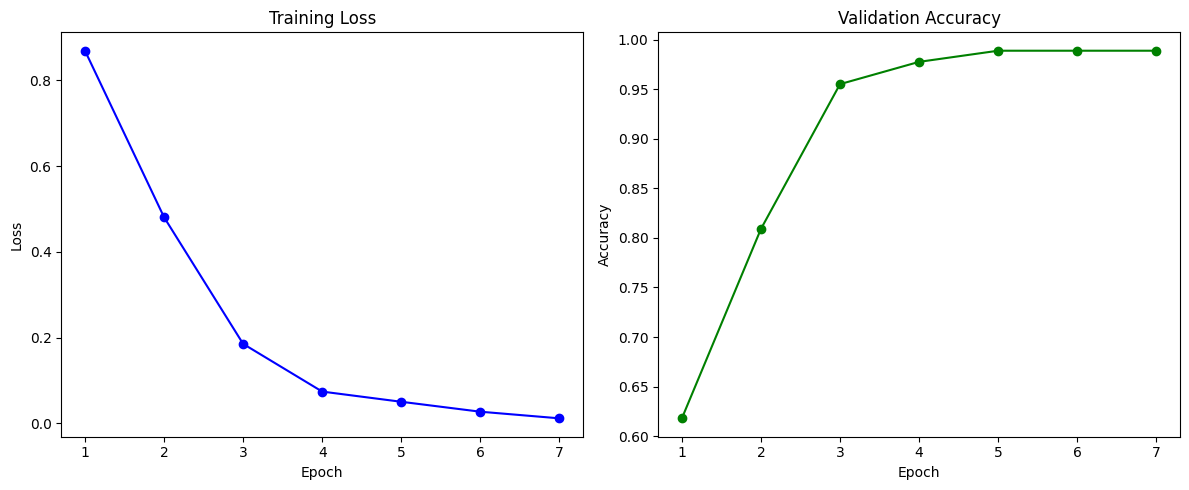

In [112]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'g-o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [116]:
# Final evaluation summary
print("\nBest Validation Accuracy: {:.4f}".format(best_val_accuracy))

# Updated label names
target_names = ['Negative', 'Neutral', 'Positive']

# Classification report
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))


Best Validation Accuracy: 0.9888
              precision    recall  f1-score   support

    Negative     0.9524    1.0000    0.9756        20
     Neutral     1.0000    0.9286    0.9630        14
    Positive     1.0000    1.0000    1.0000        55

    accuracy                         0.9888        89
   macro avg     0.9841    0.9762    0.9795        89
weighted avg     0.9893    0.9888    0.9887        89



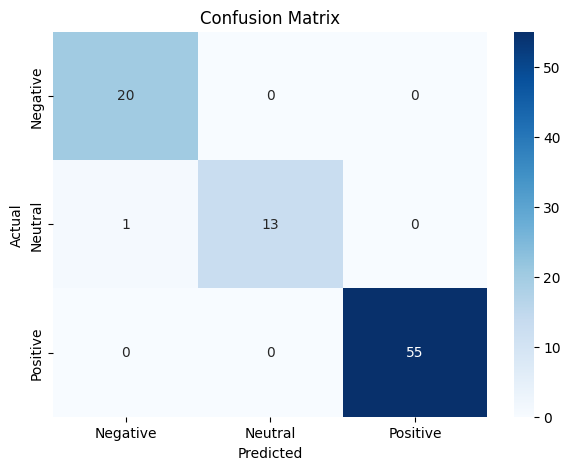

In [114]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()